# 遗传算法

遗传算法的步骤：

1. 生成基因组，基因组是由0和1组成的二进制数
2. 定义适应度函数，得到适应度 (fitness)
3. 选择，在当前基因组集合中，以较高的概率选取适应度高的基因组
4. 交叉，由夫代基因组通过交叉获得子代基因组 (crossover)
5. 变异，基因组有一定几率发生变异 (matation)

将以上过程迭代n次......

## 1. 一个简单的任务

我们先用遗传算法实现一个简单的任务：**寻找使`foo(x) = 0`的x值**

In [1]:
# 绘图通用函数
import matplotlib.pyplot as plt 
import matplotlib


def draw(x_list, y_list):
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 设置字体，使汉字能够正常显示
    plt.rcParams['text.color'] = 'black'  # 设置字体颜色
    matplotlib.rcParams['font.size'] = 15.0  # 设置字体大小

    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)  # 设置图片的长和高

    plt.plot(x_list, y_list)
    plt.show()


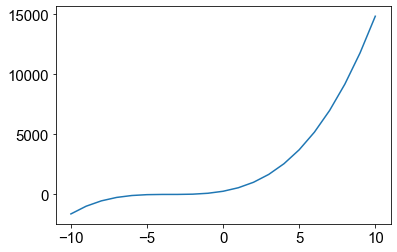

In [2]:
# your function here
def foo(x):
    return 6 * (x + 3.53) ** 3 - 13.7

x = [i for i in range(-10, 11)]
y = [foo(e) for e in x]
draw(x, y)

通过数学的方法，我们可以轻易地知道使得`foo(x)=0`成立的`x = (13.7 / 6) ** (1/3) - 3.53`, x = -2.213190031442135.

让我们看看遗传算法可以得到怎样的近似结果～

In [3]:
import sys
import random


class GeneticAlgorithm:
    """genetic algorithm"""

    def __init__(self, x_min, x_max, foo, population_size=1000, selection_size=100, generation_num=100, mutation_rate=10 ** -2, accuracy=10, threshold=10 ** 3):
        self.x_min = x_min  # 自变量x的寻参范围（最小值）
        self.x_max = x_max  # 自变量x的寻参范围（最大值）
        self.foo = foo  # 本例为寻找函数的零点，foo即为该函数
        self.population_size = population_size  # 基因组的数量（1 generation）
        self.selection_size = selection_size  # 每轮迭代中，有资格“生育”的基因组的数量
        self.generation_num = generation_num  # 基因组迭代轮数
        self.mutation_rate = mutation_rate  # 基因组发生变异概率
        self.accuracy = accuracy  # 基因组所能表达的数值的精度为小数点后accuracy位
        self.threshold = threshold  # fitness值达到threshold值时，退出循环
        self.genome_length = max(len(self.init_genome(x_min)), len(self.init_genome(x_max)))  # 基因组（01字符串）的长度

    def init_genome(self, x: float) -> str:
        x_int = int(x * 10 ** self.accuracy)
        return bin(x_int).replace('0b', '')

    def generate_genome(self, x: float) -> str:
        x_int = int(x * 10 ** self.accuracy)
        return bin(x_int).replace('0b', '').zfill(self.genome_length)

    def translate(self, genome: str) -> float:
        return int(genome, 2) * 10 ** - self.accuracy

    def fitness(self, x: int) -> float:
        if self.foo(x) == 0:
            return sys.maxsize
        else:
            return abs(1/self.foo(x))

    def init_population(self) -> list:
        return [random.uniform(self.x_min, self.x_max) for _ in range(self.population_size)]

    def selection_pair(self, population) -> tuple:
        return random.sample(population, 2)

    def crossover(self, pair: tuple) -> str:
        if len(pair) != 2 or len(pair[0]) != self.genome_length or len(pair[1]) != self.genome_length:
            raise Exception(f'pair error: {pair}')
        p = random.randint(0, self.genome_length)
        return ''.join([pair[0][:p], pair[1][p:]])

    def mutation(self, gemome: str, mutation_rate: float) -> str:
        for i in range(self.genome_length):
            r = random.random()
            if r < mutation_rate:
                replacement = '0' if gemome[i] == '1' else '1'
                gemome = gemome[:i] + replacement + gemome[i+1:]

        return gemome

    def run(self):
        population = self.init_population()
        for index in range(self.generation_num):
            solutions = []
            for p in population:
                solutions.append((p, self.fitness(p)))
            sorted_solutions = sorted(solutions, key=lambda e: e[1], reverse=True)

            # 满足阈值退出
            best_fitness = sorted_solutions[0][1]
            print(f"===gen {index}: {sorted_solutions[0]}===")
            if best_fitness > self.threshold:
                return sorted_solutions[0][0]

            # 选择
            selection = [e[0] for e in sorted_solutions[:self.selection_size]]

            # 翻译：数值 -> 基因组
            genomes = [self.generate_genome(e) for e in selection]
            new_generation = []
            for _ in range(self.population_size):
                # 交叉
                pair = self.selection_pair(genomes)
                new_genome = self.crossover(pair)

                # 变异
                new_genome = self.mutation(new_genome, self.mutation_rate)

                # 翻译：基因组 -> 数值
                new_generation.append(self.translate(new_genome))

            population = new_generation

        # 满足阈值退出
        best_fitness = sorted_solutions[0][1]
        if best_fitness > self.threshold:
            return sorted_solutions[0][0]
        else:
            print('can not find the solution.')

        return None


if __name__ == '__main__':
    g = GeneticAlgorithm(x_min=-10, x_max=10, foo=lambda x: 6 * (x + 3.53) ** 3 - 13.7)
    print('res:', g.run())


===gen 0: (-2.2266641367311717, 2.4023307115792574)===
===gen 1: (-2.2032191779, 3.1890742374753693)===
===gen 2: (-2.2132333781, 739.1625617552302)===
===gen 3: (-2.2132301021000003, 799.591238739982)===
===gen 4: (-2.2131806496, 3414.994971588051)===
res: -2.2131806496


## 2. 寻找最优拟合曲线

首先，我们构造一组样本数据。然后：

1. 用最小二乘法绘制拟合曲线
2. 用遗传算法近似计算最小化残差平方和的曲线

我们希望用1、2两种方法绘制的拟合曲线几近重合，让我们看看最终结果是否符合我们的预期。


### (1) 构造样本数据集


In [4]:
import random

# n为样本数
n = 10

# 自变量x
x = list(range(n))

# 利用random函数一次性生成y的值，然后记录下来
foo = lambda e: 3 * e + 2

# 因变量y
y = [foo(i) + random.choice([-1, 1]) * random.randint(1, 8) * random.random() for i in x]

print(f'x: {x}')
print(f'y: {y}')

x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y: [2.7623223947687303, 4.338905041732245, 7.9316423205878, 12.704009937435872, 13.844996357562719, 12.790235950569091, 21.23504673015577, 20.57083566361399, 31.08470115102174, 31.837678545808078]


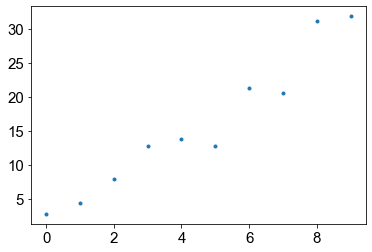

In [5]:
# 绘制样本曲线
import matplotlib.pyplot as plt

plt.plot(x, y , '.')

### (2) 最小二乘法的拟合曲线

根据最小二乘法的计算公式，我们可以得到斜率$\beta_{1}$和截距$\beta_{0}$的估计量。

$\hat{\beta}_{1}=\frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}$

$\hat{\beta}_{0}=\bar{y}-\hat{\beta}_{1} \bar{x}$

In [6]:
import numpy as np

mean_x, mean_y = np.mean(x), np.mean(y)

beta_1 = sum([(xx - mean_x) * (yy - mean_y) for xx, yy in zip(x, y)]) / sum([(xx - mean_x) ** 2 for xx in x])

beta_0 = mean_y - beta_1 * mean_x

print(f'mean_x: {mean_x}')
print(f'mean_y: {mean_y}')
print(f'beta_1: {beta_1}')
print(f'beta_0: {beta_0}')

mean_x: 4.5
mean_y: 15.910037409325602
beta_1: 3.25232178673138
beta_0: 1.274589369034393


我们来绘制最小二乘法的拟合曲线

ols_x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ols_y: [1.274589369034393, 4.526911155765773, 7.779232942497153, 11.031554729228533, 14.283876515959912, 17.53619830269129, 20.788520089422676, 24.040841876154055, 27.293163662885433, 30.545485449616812]


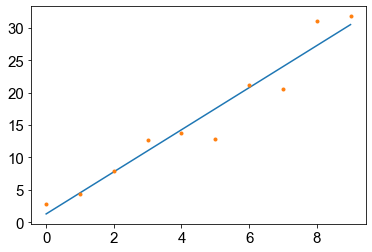

In [7]:
import matplotlib.pyplot as plt

X_RANGE = (0, n)

foo = lambda e: beta_1 * e + beta_0

ols_x = [e for e in range(*X_RANGE)]
ols_y = [foo(i) for i in ols_x]

print(f'ols_x: {ols_x}')
print(f'ols_y: {ols_y}')

# 画图
plt.plot(ols_x, ols_y , '-')  # 绘制OLS曲线
plt.plot(x, y , '.')  # 绘制样本曲线

### (3) 用遗传算法近似计算拟合曲线

接下来，我们利用遗传算法，通过最小化残差的平方和，来近似地计算拟合曲线。

在新的遗传算法实例中，我们需要调整的参数只有两个，分别是: beta_1和beta_0.

为了让遗传算法得以实现，我们必须要在上面那个遗传算法类的基础上作出一些改进：

1. 必须给出beta_1和beta_0的寻参范围
2. 上面的类是单参数寻优，我们需要改成双参数寻优
3. 我们需要改造fitness函数

In [8]:
# input

# 样本数据
sample_xlist, sample_ylist = x, y

# 寻参范围
beta0_min= int(beta_0) - 5
beta0_max= int(beta_0) + 5
beta1_min= int(beta_1) - 5
beta1_max= int(beta_1) + 5

In [9]:
# 双参数遗传算法

import sys
import random


class GeneticAlgorithm2Args:
    """genetic algorithm with 2 arguments"""

    def __init__(self, beta0_min, beta0_max, beta1_min, beta1_max, arg_num, sample_xlist, sample_ylist, population_size=1000, selection_size=100, generation_num=100, mutation_rate=10 ** -2, accuracy=10, threshold=10 ** -2, convergent_value=10 ** -6):
        self.beta0_min = beta0_min
        self.beta0_max = beta0_max
        self.beta1_min = beta1_min
        self.beta1_max = beta1_max
        self.arg_num = arg_num
        self.sample_xlist = sample_xlist
        self.sample_ylist = sample_ylist
        self.population_size = population_size
        self.selection_size = selection_size
        self.generation_num = generation_num
        self.mutation_rate = mutation_rate
        self.accuracy = accuracy
        self.threshold = threshold
        self.genome_length = max([len(self.init_genome(var)) for var in {beta0_min, beta0_max, beta1_min, beta1_max}])
        self.convergent_value = convergent_value

    def init_genome(self, var: float) -> str:
        var_int = int(var * 10 ** self.accuracy)
        return bin(var_int).replace('0b', '')

    def generate_genome(self, var: float) -> str:
        var_int = int(var * 10 ** self.accuracy)
        return bin(var_int).replace('0b', '').zfill(self.genome_length)

    def translate(self, genome: str) -> float:
        return int(genome, 2) * 10 ** - self.accuracy

    def fitness(self, vars: tuple) -> float:
        """适应性函数：最小化残差平方和

        Args:
            vars (tuple): (beta0, beta1)

        Returns:
            float: 适应值（值越小效果越好）
        """
        return sum([(y - vars[0] - vars[1] * x) ** 2 for x, y in zip(self.sample_xlist, self.sample_ylist)])

    def init_population(self, var_min: float, var_max: float) -> list:
        return [random.uniform(var_min, var_max) for _ in range(self.population_size)]

    def selection_pair(self, population, arg_num: int) -> list:
        return [random.sample([e[index] for e in population], 2) for index in range(arg_num)]

    def crossover(self, pairs: list) -> list:
        new_pairs = []
        for pair in pairs:
            if len(pair) != 2 or len(pair[0]) != self.genome_length or len(pair[1]) != self.genome_length:
                raise Exception(f'pair error: {pair}')
            p = random.randint(0, self.genome_length)
            new_pairs.append(''.join([pair[0][:p], pair[1][p:]]))

        return new_pairs

    def mutation(self, gemomes: str, mutation_rate: float) -> list:
        new_gemomes = []
        for gemome in gemomes:
            for i in range(self.genome_length):
                r = random.random()
                if r < mutation_rate:
                    replacement = '0' if gemome[i] == '1' else '1'
                    gemome = gemome[:i] + replacement + gemome[i+1:]
            new_gemomes.append(gemome)

        return new_gemomes

    def run(self):
        fitness_list = [0 for _ in range(2)]

        # 随机化beta0和beta1的初始值
        population = [(beta0, beta1) for beta0, beta1 in zip(self.init_population(self.beta0_min, self.beta0_max), self.init_population(self.beta1_min, self.beta1_max))]
        for index in range(self.generation_num):
            solutions = []
            for p in population:
                solutions.append((p, self.fitness(p)))
            sorted_solutions = sorted(solutions, key=lambda e: e[1], reverse=False)

            # 满足阈值退出
            best_fitness = sorted_solutions[0][1]
            print(f"===gen {index}: {sorted_solutions[0]}===")
            if best_fitness < self.threshold:
                return sorted_solutions[0][0]
            
            # 记录最近两轮的fitness值
            fitness_list.append(best_fitness)
            fitness_list = fitness_list[-2:]

            # 检查是否收敛
            if abs(fitness_list[0] - fitness_list[1]) < self.convergent_value:
                # 假设最后两轮fitness值相差小于self.convergent_value为收敛
                return sorted_solutions[0][0]

            # 选择
            selection = [e[0] for e in sorted_solutions[:self.selection_size]]

            # 翻译：数值 -> 基因组
            genomes = [tuple(self.generate_genome(elem) for elem in elems) for elems in selection]

            new_generation = []
            for _ in range(self.population_size):
                # 交叉
                pairs = self.selection_pair(genomes, self.arg_num)
                new_genomes = self.crossover(pairs)

                # 变异
                new_genomes = self.mutation(new_genomes, self.mutation_rate)

                # 翻译：基因组 -> 数值
                new_generation.append(tuple(self.translate(new_genome) for new_genome in new_genomes))

            population = new_generation

        return None


if __name__ == '__main__':
    g = GeneticAlgorithm2Args(beta0_min=beta0_min, beta0_max=beta0_max, beta1_min=beta1_min, beta1_max=beta1_max, arg_num=2, sample_xlist=sample_xlist, sample_ylist=sample_ylist)
    esti_beta0, esti_beta1 = g.run()
    print('res:', (esti_beta0, esti_beta1))


===gen 0: ((0.8295798188339933, 3.290718046802011), 56.93435353969996)===
===gen 1: ((1.1746960661, 3.2680322488), 56.100540746457625)===
===gen 2: ((1.1870657576, 3.2620236834000003), 56.09866092591203)===
===gen 3: ((1.1870657692, 3.2678240309), 56.09463580028024)===
===gen 4: ((1.2352695495000001, 3.2620236998000003), 56.07960775379081)===
===gen 5: ((1.2352726526, 3.2576632422), 56.07634267026923)===
===gen 6: ((1.2291728668000002, 3.2629870673), 56.08110466569928)===
===gen 7: ((1.2313485842, 3.2625718777), 56.0804050363867)===
===gen 8: ((1.2296614918, 3.2615330823), 56.0787748714688)===
===gen 9: ((1.2352709818, 3.2615330823), 56.07869944602218)===
===gen 10: ((1.2313482676, 3.2615068679), 56.078650600928015)===
===gen 11: ((1.233445829, 3.2615068679), 56.07861454571542)===
===gen 12: ((1.2334461958, 3.2614921458), 56.07859204562897)===
===gen 13: ((1.233445829, 3.2614920309), 56.078591869599514)===
res: (1.233445829, 3.2614920309)


上面运行结果中的$res[0]$是$beta0$的估计值，$res[1]$是$beta1$的估计值。

试比较遗传算法是否比较精确地估计出了用最小二乘法计算出的估计值。如果估计比较精确，则我们可以认为：“最小二乘法公式”和“最小化残差平方和”两种方法是殊途同归的。

绘制遗传算法估计的拟合曲线：

genome_x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
genome_y: [1.233445829, 4.4949378599, 7.7564298908, 11.017921921700001, 14.2794139526, 17.5409059835, 20.8023980144, 24.0638900453, 27.3253820762, 30.5868741071]


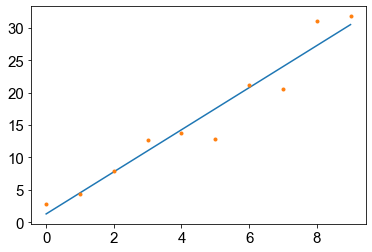

In [10]:
import matplotlib.pyplot as plt

X_RANGE = (0, n)

foo = lambda e: esti_beta1 * e + esti_beta0

genome_x = [e for e in range(*X_RANGE)]
genome_y = [foo(i) for i in genome_x]

print(f'genome_x: {genome_x}')
print(f'genome_y: {genome_y}')

# 画图
plt.plot(ols_x, ols_y , '-')  # 绘制最小化残差平方和的曲线（采用遗传算法近似计算）
plt.plot(x, y , '.')  # 绘制样本曲线